In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from collections import OrderedDict, defaultdict

In [2]:
dataSet = pd.read_csv("Faithful.csv",header=None)
dataSet.columns = ["No", "Eruptions", "Waiting Time"]


### Split data

In [3]:
training_data = dataSet[:250]
testing_data = dataSet[250:]

train_X = training_data[["Eruptions"]].values
train_Y = training_data[["Waiting Time"]].values

test_X = testing_data[["Eruptions"]].values
test_Y = testing_data[["Waiting Time"]].values

### Definitions  

In [4]:
def trainData(x,k = 2):
    n = x.shape[0]
    p = x.shape[1]

    phi = np.random.rand(k,p)
    sigma_phi = np.sum(phi)
    phi = phi/sigma_phi
    mu = np.random.rand(k,p)
    sigma = np.random.rand(k,p)    
    w = np.ndarray(shape=(n,k,p))
    preW = np.ndarray(shape=(p))
    itr = 0
    isConverged = False
    
    while not isConverged:
        if itr >= 1000:
            break
        itr+=1

        sum_of_all_probability = np.zeros((n,1,p))
        probability = np.zeros((n,k,p))
        for i in range(n):
            for j in range(k):
                dij = x[i] - mu[j] 
                dijSquare = - ( dij.T * dij )
                sigSquare = 2 * sigma[j]**2
                tempExp = np.exp( dijSquare / sigSquare )
                constant = 1 / ( (2*math.pi)**(p/2) * sigma[j] )
                probability[i,j] = ( constant * tempExp * phi[j] )
                sum_of_all_probability[i] += probability[i,j]

        preW = np.copy(w)
        for i in range(n):
                for j in range(k):
                    w[i,j] = probability[i,j] / sum_of_all_probability[i]
        
        if (preW == w).all():
            isConverged = True
            
        for j in range(k):
            sum_W_X_MU = 1
            sum_W_X = 1
            sum_W = 2
            
            for i in range(n):
                sum_W_X +=  w[i,j] * x[i]
                sum_W += w[i,j]  
            mu[j] = sum_W_X / sum_W
            
            for i in range(n):
                sum_W_X_MU += w[i,j] * (x[i]-mu[j])**2                
            sigma[j] = ( sum_W_X_MU / sum_W )**0.5
            
            phi[j] = sum_W / n
              
    return w, mu, sigma, phi

In [5]:
def probability(x, mu, sigma, phi, k = 2):
    n = x.shape[0]
    p = x.shape[1]
    w = np.ndarray(shape=(n,k,p))
    sum_of_all_probability = np.zeros((n,1,p))
    probability = np.zeros((n,k,p))
    
    for i in range(n):
        for j in range(k):
            dij = x[i] - mu[j] 
            dijSquare = - ( dij.T * dij )
            sigSquare = 2 * sigma[j]**2
            tempExp = np.exp( dijSquare / sigSquare )
            constant = 1 / ( (2*math.pi)**(p/2) * sigma[j] )
            probability[i,j] = ( constant * tempExp * phi[j] )
            sum_of_all_probability[i] += probability[i,j]
    
    preW = np.copy(w)       
    for i in range(n):
            for j in range(k):
                w[i,j] = probability[i,j] / sum_of_all_probability[i]
    return w

In [6]:
def ErrorFunction (w, mu, sigma, phi, x, k):
    n = x.shape[0]
    p = x.shape[1]
    
    funJ = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            const = math.log( 1/ (2* math.pi)**(p/2) )
            lnSig = np.log( sigma[j] )
            
            dijSquare = (x[i] - mu[j])**2
            sigSquare = 2 * sigma[j]**2
            exp = dijSquare/sigSquare
            
            lnPhi = np.log( phi[j] )
            lnW = np.log ( w[i,j] )
            
            funJ += w[i,j] * ( const - lnSig - exp + lnPhi - lnW )
    
    return funJ

In [7]:
def CreateDict(w):
    dic = defaultdict(list)
    i = 0
    for c in w:
        if c[0] > 0.5:
            dic[0].append(i)
        if c[1] > 0.5:
            dic[1].append(i)
        i += 1 
    return dic

def PlotGraph(data, dic):
    for rowind in range(0, len(data)):
        temp = data.iloc[[rowind]]
        if rowind in dic[0]:
            plt.plot(temp["Eruptions"],temp["Waiting Time"], 'b+')
        else:
            plt.plot(temp["Eruptions"],temp["Waiting Time"], 'r+')

Classifying the Data into clusters

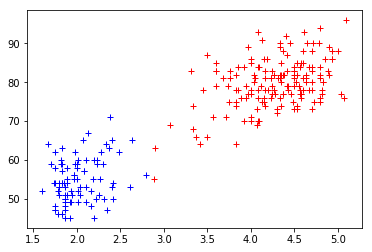

In [8]:
w, mu, sigma, phi = trainData(train_X , 2)
J = ErrorFunction(w, mu, sigma, phi, train_X ,2)
trainingCluster = CreateDict(w)
PlotGraph(training_data, trainingCluster)

In [9]:
train_clutster_1 = training_data.loc[ training_data["No"].isin( trainingCluster[0] ) ]
train_clutster_2 = training_data.loc[ training_data["No"].isin( trainingCluster[1] ) ]

train_X_clutster_1 = train_clutster_1[["Eruptions"]].values
train_Y_clutster_1 = train_clutster_1[["Waiting Time"]].values

train_X_clutster_2 = train_clutster_2[["Eruptions"]].values
train_Y_clutster_2 = train_clutster_2[["Waiting Time"]].values

def Linear_Train(training_data_X, training_data_Y):
    xT = np.transpose(training_data_X)
    xTx = np.matmul ( xT, training_data_X )
    inverse_xTx = np.linalg.inv ( xTx )
    xTy = np.matmul ( xT, training_data_Y )
    theta_function =  np.matmul (inverse_xTx, xTy)
    return theta_function

def Cal_Error(validating_data_X, validating_data_Y, theta_function):
    #Now Validation of Data
    error_function = ( np.matmul( validating_data_X, theta_function ) - validating_data_Y ) ** 2
    mean_square_error = np.sum(error_function)
    root_mean_square_error = np.sqrt(mean_square_error) / np.size(error_function)
    return root_mean_square_error

theta_cluster_1 = Linear_Train(train_X_clutster_1,train_Y_clutster_1)
theta_cluster_2 = Linear_Train(train_X_clutster_2,train_Y_clutster_2)

In [10]:
rmse_1 = Cal_Error(train_X_clutster_1,train_Y_clutster_1,theta_cluster_1)
rmse_2 = Cal_Error(train_X_clutster_2,train_Y_clutster_2,theta_cluster_2)

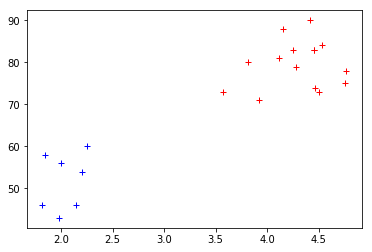

In [11]:
predict_w = probability(test_X, mu, sigma, phi)
predictCluster  = CreateDict(predict_w)

predict_Y = np.ndarray((test_Y.shape[0], test_Y.shape[1]))

for rowind in range(len(test_X)):
    temp = test_X[rowind,:]
    if rowind in predictCluster[0]:
        predict_Y[rowind] = np.matmul(temp, theta_cluster_1)
    else:
        predict_Y[rowind] = np.matmul(temp, theta_cluster_2)
        
PlotGraph(testing_data, predictCluster)

Text(0, 0.5, 'Waiting')

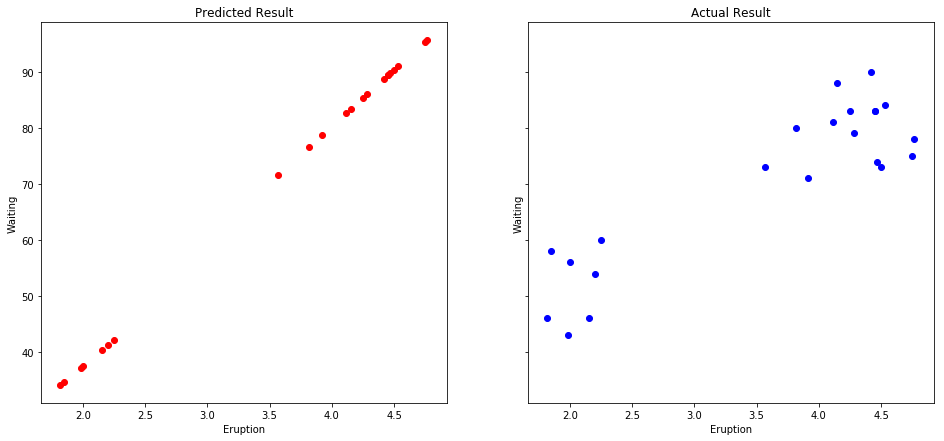

In [12]:
fig, arr = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

fig.set_figwidth(16)
fig.set_figheight(7)

arr[0].scatter (test_X[:,0], predict_Y, c='r' )
arr[0].set_title('Predicted Result')
arr[0].set_xlabel('Eruption')
arr[0].set_ylabel('Waiting')

arr[1].scatter (test_X[:,0], test_Y, c='b' )
arr[1].set_title('Actual Result')
arr[1].set_xlabel('Eruption')
arr[1].set_ylabel('Waiting')

Text(0.5, 1.0, 'Actual Result')

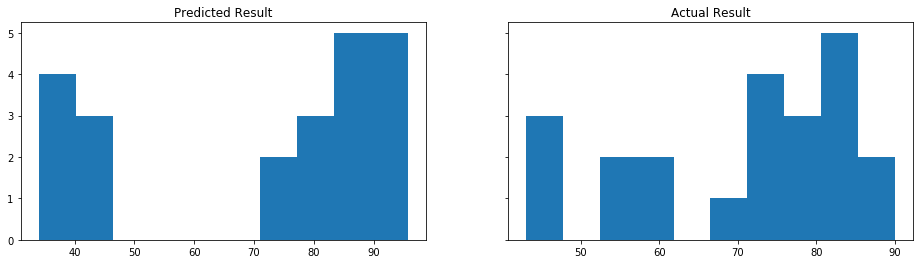

In [13]:
fig, arr = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

fig.set_figwidth(16)
fig.set_figheight(4)

arr[0].hist(predict_Y)
arr[0].set_title('Predicted Result')

arr[1].hist(test_Y)
arr[1].set_title('Actual Result')